In [1]:
import torch
from torch import tensor
from torch.types import Tensor
from math import *

# Refactoring Goals
- Remove confusion between numpy and torch vectorisations
- Use builtin maths for scalars
- Use torch.tensor for everything else
- Tighten up the data type headaches
- Remove sliding NSGT support
- De-crustify the legacy code
- Make the pytorch code more idiomatic



In [2]:



class Scale:
    dbnd = 1.e-8
    F : Tensor = None
    Q : Tensor = None

    def F_by_bnd(self, bnd_index: Tensor):
        return self.F[bnd_index]
    
    def Q_by_bnd(self, bnd_index: Tensor):
        return self.Q[bnd_index]

    def __init__(self, bnds):
        self.bnds = bnds

    def __len__(self):
        return self.bnds

class OctScale(Scale):
    def __init__(self, fmin, fmax, bpo, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bpo: bands per octave (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        lfmin = log2(fmin)
        lfmax = log2(fmax)
        bnds = int(ceil((lfmax-lfmin)*bpo))+1
        Scale.__init__(self, bnds+beyond*2)
        odiv = (lfmax-lfmin)/(bnds-1)
        lfmin_ = lfmin-odiv*beyond
        lfmax_ = lfmax+odiv*beyond
        self.fmin = 2**lfmin_
        self.fmax = 2**lfmax_
        self.pow2n = 2**odiv
        q = sqrt(self.pow2n)/(self.pow2n-1.)/2.

        self.Q = tensor([q])
        self.F = tensor(self.fmin*self.pow2n**(torch.arange(self.bnds)))



class LinScale(Scale):
    def __init__(self, fmin, fmax, bnds, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bnds: number of frequency bands (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        self.df = float(fmax-fmin)/(bnds-1)
        Scale.__init__(self, bnds+beyond*2)
        self.fmin = float(fmin)-self.df*beyond
        if self.fmin <= 0:
            raise ValueError("Frequencies must be > 0.")
        self.fmax = float(fmax)+self.df*beyond
        self.F = torch.arange(self.bnds)*self.df+self.fmin
        self.Q = self.F / (self.df*2)


def hz2mel(f):
    "\\cite{shannon:2003}"
    if isinstance(f, Tensor):
        return torch.log10(f/700.+1.)*2595.
    else:
        return log10(f/700.+1.)*2595


def mel2hz(m):
    "\\cite{shannon:2003}"
    return (10.0**(m/2595.)-1)*700


class MelScale(Scale):
    def __init__(self, fmin, fmax, bnds, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bnds: number of frequency bands (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        mmin = hz2mel(fmin)
        mmax = hz2mel(fmax)
        Scale.__init__(self, bnds+beyond*2)
        self.fmin = float(fmin)
        self.fmax = float(fmax)
        self.mbnd = (mmax-mmin)/(bnds-1)  # mels per band
        self.mmin = mmin-self.mbnd*beyond
        self.mmax = mmax+self.mbnd*beyond

        mels = torch.arange(bnds) * self.mbnd + self.mmin

        self.F = mel2hz(mels)

        odivs = (torch.exp(mels/-1127.)-1.) * (-781.177/self.mbnd)
        pow2n = 2.0 ** (1./odivs)
        self.Q = pow2n.sqrt()/ (pow2n-1.)/2.
    


C:\Users\MInf\AppData\Local\Temp\ipykernel_30592\3050824821.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.F = tensor(self.fmin*self.pow2n**(torch.arange(self.bnds)))


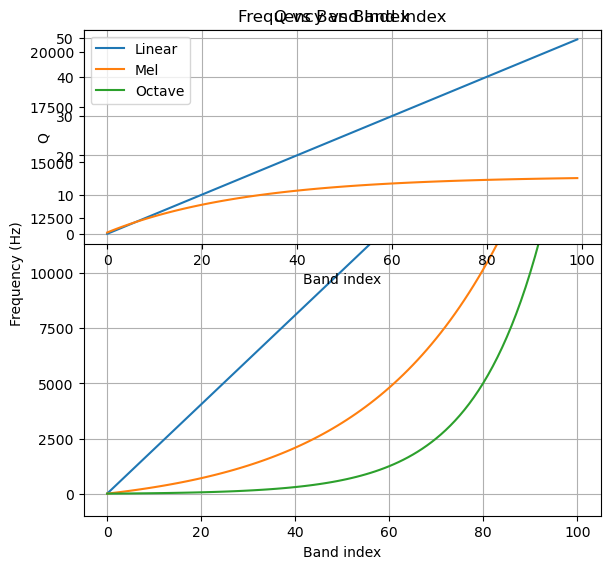

In [3]:
import matplotlib.pyplot as plt

# Create example scales
lin_scale = LinScale(20, 20000, 100)
mel_scale = MelScale(20, 20000, 100)
oct_scale = OctScale(20, 20000, 10)

# Plot frequency scales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lin_scale.F, label='Linear')
plt.plot(mel_scale.F, label='Mel')
plt.plot(oct_scale.F, label='Octave')
plt.xlabel('Band index')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs Band Index')
plt.legend()
plt.grid(True)

plt.subplot(2,2,1)
plt.plot(lin_scale.Q, label='Linear')
plt.plot(mel_scale.Q, label='Mel')
plt.plot(oct_scale.Q, label='Octave')
plt.xlabel('Band index')
plt.ylabel('Q')
plt.title('Q vs Band Index')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


In [4]:
def hannwin(l):
    r = torch.arange(l,dtype=float)
    r *= torch.pi*2./l
    r = torch.cos(r)
    r += 1.
    r *= 0.5
    return r



In [5]:
from warnings import warn

"""
Thomas Grill, 2011-2015
http://grrrr.org/nsgt

--
        Original matlab code comments follow:

NSGFWIN.M
---------------------------------------------------------------
 [g,rfbas,M]=nsgfwin(fmin,bins,sr,Ls) creates a set of windows whose
 centers correspond to center frequencies to be
 used for the nonstationary Gabor transform with varying Q-factor. 
---------------------------------------------------------------

INPUT : fmin ...... Minimum frequency (in Hz)
        bins ...... Vector consisting of the number of bins per octave
        sr ........ Sampling rate (in Hz)
        Ls ........ Length of signal (in samples)

OUTPUT : g ......... Cell array of window functions.
         rfbas ..... Vector of positions of the center frequencies.
         M ......... Vector of lengths of the window functions.

AUTHOR(s) : Monika Dörfler, Gino Angelo Velasco, Nicki Holighaus, 2010

COPYRIGHT : (c) NUHAG, Dept.Math., University of Vienna, AUSTRIA
http://nuhag.eu/
Permission is granted to modify and re-distribute this
code in any manner as long as this notice is preserved.
All standard disclaimers apply.

EXTERNALS : firwin
"""

def nsgfwin(f : Tensor, q: Tensor, sr, Ls, min_win=4, do_warn=True, dtype=torch.float64) -> tuple[list, Tensor, Tensor]:
    """
    f: list of center frequencies
    q: list of Q-factors
    sr: sampling rate
    Ls: length of signal
    min_win: minimum window length

    Returns:
        g: list of window functions
        rfbas: list of center frequencies
        M: list of window lengths
    """

    nyquist_f = sr/2.0

    mask = f > 0
    lim = torch.argmax(mask.int())
    if mask.any():
        # f partly <= 0 
        f = f[lim:]
        q = q[lim:]
            
    mask = f >= nyquist_f
    lim = torch.argmax(mask.int())
    if mask.any():
        # f partly >= nf 
        f = f[:lim]
        q = q[:lim]
    
    # assert len(f) == len(q)
    assert torch.all((f[1:]-f[:-1]) > 0)  # frequencies must be monotonic
    assert torch.all(q > 0)  # all q must be > 0
    
    qneeded = f*(Ls/(8.*sr))
    if torch.any(q >= qneeded) and do_warn:
        warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
    
    fbas : Tensor[int] = f
    lbas : int = len(fbas)
    frqs = torch.concatenate([
        tensor([0.0])
        ,f,
        tensor([nyquist_f])
    ])
    fbas = torch.concatenate([frqs, tensor([sr]) - torch.flip(f, (0,))])

    fbas *= float(Ls)/sr

    M : Tensor = torch.zeros(fbas.shape, dtype=int)

    M[0] = torch.round(2*fbas[1])
    for k in range(1,2*lbas+1):
        M[k] = torch.round(fbas[k+1]-fbas[k-1])
    M[-1] = torch.round(Ls-fbas[-2])

    M = torch.clip(M, min_win, torch.inf)

    g : list = [hannwin(m) for m in M]

    fbas[lbas] = (fbas[lbas-1]+fbas[lbas+1])/2
    fbas[lbas+2] = Ls-fbas[lbas]
    rfbas = torch.round(fbas).to(int)

    return g, rfbas, M


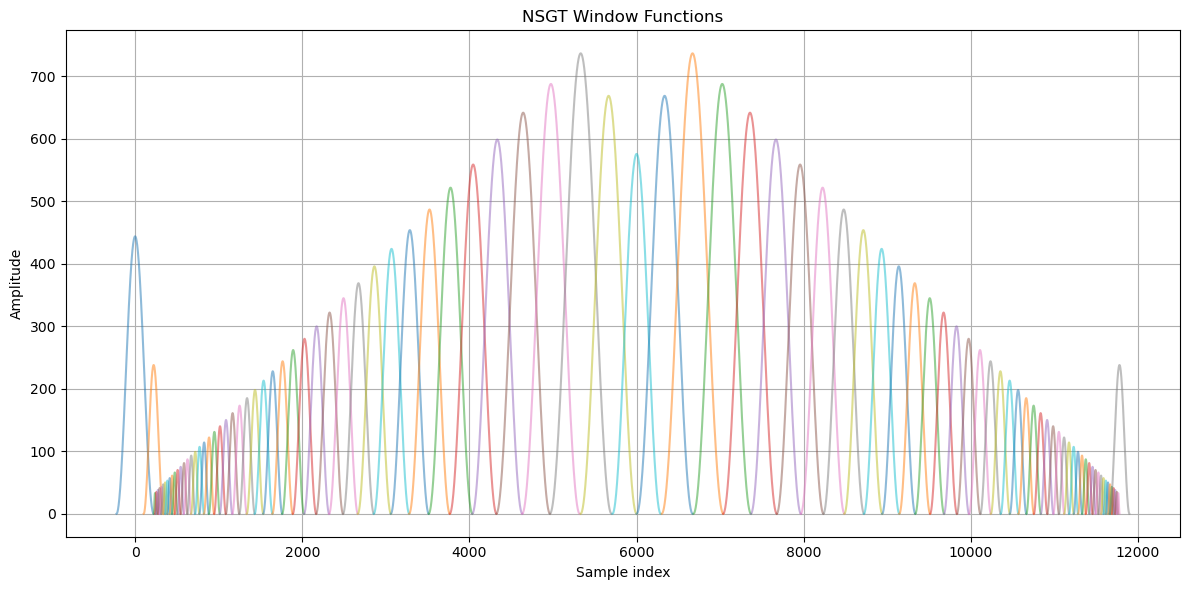

In [6]:
f = oct_scale.F
q = oct_scale.Q

sr = 1080
Ls = 12000

g, rfbas, M = nsgfwin(f,q,sr,Ls)

def plot_nsgfwin_results(g, rfbas, M):
    fig, ax = plt.subplots(figsize=(12,6))
    
    # Plot each window function
    for i, window in enumerate(g):
        # Center each window at its frequency position
        center = rfbas[i]
        x = torch.arange(len(window)) + center - len(window)//2
        ax.plot(x, M[i]- window * M[i], alpha=0.5, label=f'Window {i}')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Amplitude') 
    ax.set_title('NSGT Window Functions')
    ax.grid(True)
    
    # Only show legend if there aren't too many windows
    if len(g) <= 10:
        ax.legend()
        
    plt.tight_layout()
    return fig

# Test the plotting function
f = plot_nsgfwin_results(g, rfbas, M)

In [7]:
-rfbas[-1]

tensor(-11778)

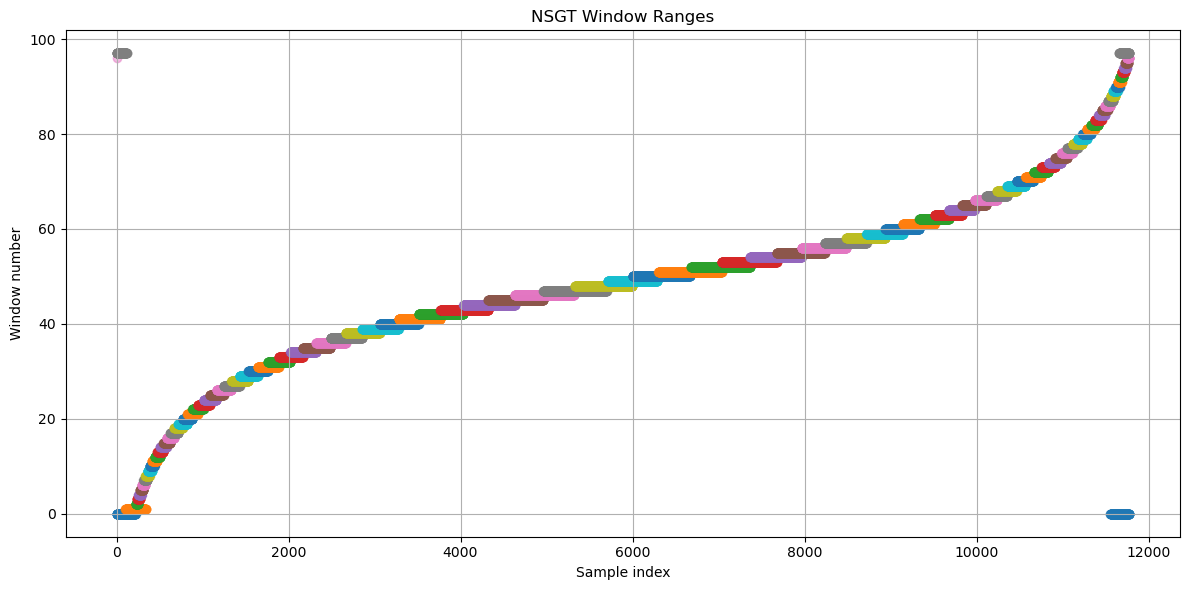

In [12]:
def calcwinrange(g : list, rfbas : Tensor, Ls : int):
    shift = torch.concatenate([
        (-rfbas[-1] % Ls).unsqueeze(0), 
        rfbas[1:]-rfbas[:-1]
    ])
    
    timepos = torch.cumsum(shift, 0)
    nn = timepos[-1]
    timepos -= shift[0] # Calculate positions from shift vector
    
    wins = []
    for gii,tpii in zip(g, timepos):
        Lg = len(gii)
        win_range = torch.arange(-(Lg//2)+tpii, Lg-(Lg//2)+tpii, dtype=int)
        win_range %= nn

        wins.append(win_range)
        
    return wins,nn


#================

# Plot the window ranges
wins, nn = calcwinrange(g, rfbas, Ls)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each window range as a scatter plot
for i, win_range in enumerate(wins):
    ax.scatter(win_range.cpu(), [i] * len(win_range), alpha=0.5, label=f'Window {i}')

ax.set_xlabel('Sample index')
ax.set_ylabel('Window number')
ax.set_title('NSGT Window Ranges')
ax.grid(True)

# Only show legend if there aren't too many windows
if len(wins) <= 10:
    ax.legend()
    
plt.tight_layout()
plt.show()


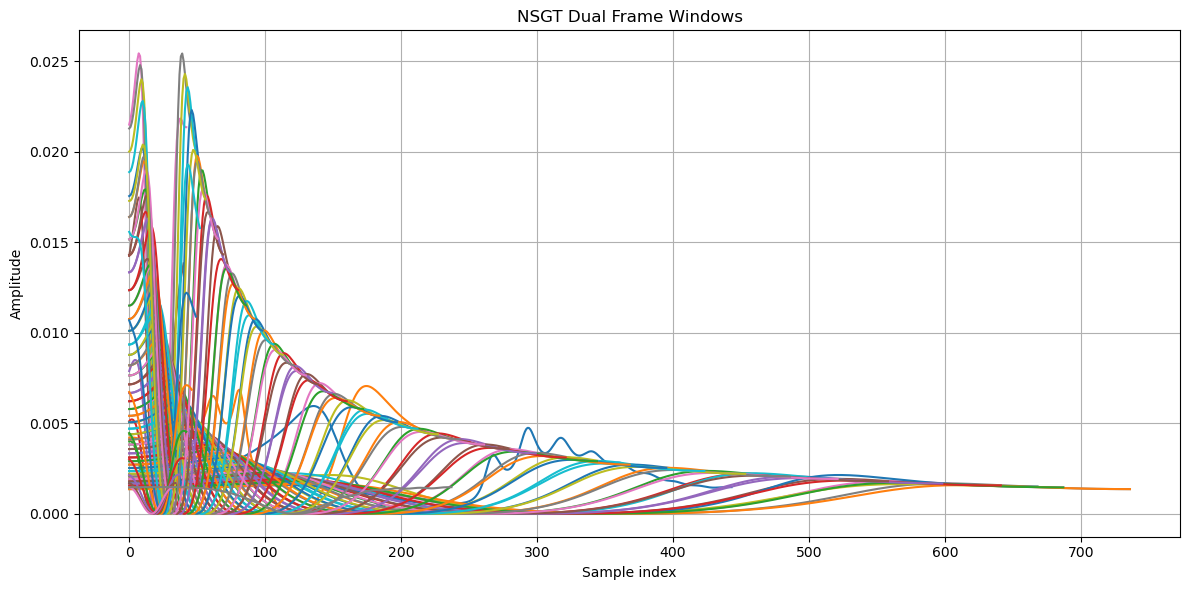

In [18]:
def nsdual(g, wins, nn, M, device="cpu"):
    # Construct the diagonal of the frame operator matrix explicitly
    x = torch.zeros((nn,), dtype=float)
    for gi,mii,sl in zip(g, M, wins):
        xa = torch.square(torch.fft.fftshift(gi))
        xa *= mii

        x[sl] += xa

    gd = [gi/torch.fft.ifftshift(x[wi]) for gi,wi in zip(g,wins)]
    return gd

# Calculate dual frame
dual_frame = nsdual(g, wins, nn, M)

# Plot the dual frame
fig, ax = plt.subplots(figsize=(12, 6))

for i, gd in enumerate(dual_frame):
    ax.plot(gd.cpu(), label=f'Dual Window {i}')

ax.set_xlabel('Sample index')
ax.set_ylabel('Amplitude')
ax.set_title('NSGT Dual Frame Windows')
ax.grid(True)

# Only show legend if there aren't too many windows
if len(dual_frame) <= 10:
    ax.legend()
    
plt.tight_layout()
plt.show()


In [ ]:
def n_coefs(M: Tensor, g: Tensor, sl: slice):
    return max(int(ceil(float(len(gii))/mii))*mii for mii,gii in zip(M[sl],g[sl]))

In [20]:
def nsgtf(f, g, wins, nn, M, real, reducedform):

    fft : function = torch.fft.fft
    ifft : function = torch.fft.ifft

    if real: 
        assert 0 <= reducedform <= 2
        sl = slice(reducedform,len(g)//2+1-reducedform)
    else: 
        sl = slice(0, None)

    maxLg = n_coefs(M, g, sl)

    loopparams = []
    for mii, gii, win_range in zip(M[sl],g[sl],wins[sl]):
        Lg = len(gii)
        col = int(ceil(float(Lg)/mii))
        assert col*mii >= Lg
        assert col == 1

        p = (mii,win_range,Lg,col)
        loopparams.append(p)

    ragged_giis = [torch.nn.functional.pad(torch.unsqueeze(gii, dim=0), (0, maxLg-gii.shape[0])) for gii in g[sl]]
    giis = torch.conj(torch.cat(ragged_giis))

    ft = fft(f)

    Ls = f.shape[-1]

    assert nn == Ls

    c = torch.zeros(*f.shape[:2], len(loopparams), maxLg, dtype=ft.dtype)

    for j, (mii,win_range,Lg,col) in enumerate(loopparams):
        t = ft[:, :, win_range]*torch.fft.fftshift(giis[j, :Lg])

        sl1 = slice(None,(Lg+1)//2)
        sl2 = slice(-(Lg//2),None)

        c[:, :, j, sl1] = t[:, :, Lg//2:]  # if mii is odd, this is of length mii-mii//2
        c[:, :, j, sl2] = t[:, :, :Lg//2]  # if mii is odd, this is of length mii//2

    return ifft(c)

from itertools import chain

def nsigtf(c, gd, wins, nn, Ls, real, reducedform):

    fft : function = torch.fft.fft
    ifft : function = torch.fft.irfft if real else torch.fft.ifft

    if real: 
        ln = len(gd) // 2+1 - reducedform *2
        if reducedform:
            sl = lambda x: chain(
                x[reducedform            : len(gd)//2+1-reducedform],
                x[len(gd)//2+reducedform :    len(gd)+1-reducedform]
            )
        else:
            ln = len(gd)
            sl = lambda x: x
    
    maxLg = max(len(gdii) for gdii in sl(gd))

    ragged_gdiis = [torch.nn.functional.pad(torch.unsqueeze(gdii, dim=0), (0, maxLg-gdii.shape[0])) for gdii in sl(gd)]
    gdiis = torch.conj(torch.cat(ragged_gdiis))

    assert type(c) == torch.Tensor
    c_shape = c.shape[:3]
    c_dtype = c.dtype
    fc = fft(c)

    fr = torch.zeros(*c_shape[:2], nn, dtype=c_dtype)  # Allocate output
    temp0 = torch.empty(*c_shape[:2], maxLg, dtype=fr.dtype)  # pre-allocation

    fbins = c_shape[2]

    loopparams = []
    for gdii,win_range in zip(sl(gd), sl(wins)):
        Lg = len(gdii)
        wr1 = win_range[:(Lg)//2]
        wr2 = win_range[-((Lg+1)//2):]
        p = (wr1,wr2,Lg)
        loopparams.append(p)

    # Overlapp-add procedure
    for i,(wr1,wr2,Lg) in enumerate(loopparams[:fbins]):
        t = fc[:, :, i]

        r = (Lg+1)//2
        l = (Lg//2)

        t1 = temp0[:, :, :r]
        t2 = temp0[:, :, Lg-l:Lg]

        t1[:, :, :] = t[:, :, :r]
        t2[:, :, :] = t[:, :, maxLg-l:maxLg]

        temp0[:, :, :Lg] *= gdiis[i, :Lg] 
        temp0[:, :, :Lg] *= maxLg

        fr[:, :, wr1] += t2
        fr[:, :, wr2] += t1

    ftr = fr[:, :, :nn//2+1] if real else fr
    sig = ifft(ftr, outn=nn)
    sig = sig[:, :, :Ls] # Truncate the signal to original length (if given)
    return sig
    

In [ ]:
# -*- coding: utf-8

"""
Python implementation of Non-Stationary Gabor Transform (NSGT)
derived from MATLAB code by NUHAG, University of Vienna, Austria

Thomas Grill, 2011-2015
http://grrrr.org/nsgt

Austrian Research Institute for Artificial Intelligence (OFAI)
AudioMiner project, supported by Vienna Science and Technology Fund (WWTF)

--
Original matlab code copyright follows:

AUTHOR(s) : Monika Dörfler, Gino Angelo Velasco, Nicki Holighaus, 2010-2011

COPYRIGHT : (c) NUHAG, Dept.Math., University of Vienna, AUSTRIA
http://nuhag.eu/
Permission is granted to modify and re-distribute this
code in any manner as long as this notice is preserved.
All standard disclaimers apply.

"""


class NSGT:
    def __init__(self, scale, fs, Ls, real=True, matrixform=False, reducedform=0):
        assert fs > 0
        assert Ls > 0
        assert 0 <= reducedform <= 2

        self.scale = scale
        self.fs = fs
        self.Ls = Ls
        self.real = real
        self.reducedform = reducedform

        # self.device = torch.device(device)

        # calculate transform parameters
        self.g,rfbas,self.M = nsgfwin(
            self.scale.F, self.scale.Q,
             self.fs, self.Ls
        )

        if real:
            assert 0 <= reducedform <= 2
            sl = slice(reducedform,len(self.g)//2+1-reducedform)
        else:
            sl = slice(0,None)

        # coefficients per slice
        self.ncoefs = max(int(ceil(float(len(gii))/mii))*mii for mii,gii in zip(self.M[sl],self.g[sl]))    

        if matrixform:
            if self.reducedform:
                rm = self.M[self.reducedform:len(self.M)//2+1-self.reducedform]
                self.M[:] = rm.max()
            else:
                self.M[:] = self.M.max()

        # calculate shifts
        self.wins,self.nn = calcwinrange(self.g, rfbas, self.Ls)
        # calculate dual windows
        self.gd = nsdual(self.g, self.wins, self.nn, self.M, device=self.device)
        
        self.fwd = lambda s: nsgtf(s, self.g, self.wins, self.nn, self.M, real=self.real, reducedform=self.reducedform)
        self.bwd = lambda c: nsigtf(c, self.gd, self.wins, self.nn, self.Ls, real=self.real, reducedform=self.reducedform)
    


    @property
    def coef_factor(self):
        return float(self.ncoefs)/self.Ls
    
    @property
    def slice_coefs(self):
        return self.ncoefs
    
    def forward(self, s):
        'transform'
        s = self.channelize(s)
        #c = list(map(self.fwd, s))
        c = self.fwd(s)
        return self.unchannelize(c)

    def backward(self, c):
        'inverse transform'
        c = self.channelize(c)
        #s = list(map(self.bwd,c))
        s = self.bwd(c)
        return self.unchannelize(s)
    
class CQ_NSGT(NSGT):
    def __init__(self, fmin, fmax, bins, fs, Ls, real=True, matrixform=False, reducedform=0, multichannel=False, measurefft=False, multithreading=False):
        assert fmin > 0
        assert fmax > fmin
        assert bins > 0
        
        self.fmin = fmin
        self.fmax = fmax
        self.bins = bins

        scale = OctScale(fmin, fmax, bins)
        NSGT.__init__(self, scale, fs, Ls, real, matrixform=matrixform, reducedform=reducedform, multichannel=multichannel, measurefft=measurefft, multithreading=multithreading)
